# ESE-2000 Lab 6
TO DO add intro

We download a ~1MB file containing the entirety of Shakespeare's work. This is the dataset we will train our language model on.

In [24]:
import torch
from tqdm import trange
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from IPython.core.display_functions import clear_output
import matplotlib.pyplot as plt
import math
import wandb
import re
device = "cpu"
# if torch.backends.mps.is_available():
#     device = "mps:0"
# elif torch.cuda.is_available():
#     device = "cuda:1" #TODO change back to 0
wandb.login()
run = wandb.init(
    project="lab-9-llm",
    entity="ese-2000",
    config={
        "architecture": "Transformer",
        "dataset": "TinyShakespeare"
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


### Data

###  Data Loading

In [25]:
with open('input.txt') as f:
    text = f.read()
    

print("----Sample Shakespeare----")
print(text[:250])

----Sample Shakespeare----
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## Tokenization

Tokenization converts raw sub-sequences of text (substrings) to sequences of integers. For example, `"ll." -> 208`. We will be developing a character level language model, so we will be converting each individual word into an integer. For example, `"Hello" -> 48`.

In [26]:
def split_to_words(text):
    return re.findall(r"\w+(?:'\w+)?|[.,!?;:\"()\[\]{}<>\\/\-—–…]|\n", text)

vocab = list(set(split_to_words(text)))
vocab_size = len(vocab)
print("Number of words: {}".format(len(split_to_words(text))))
print("Number of distinct words in text: {}".format(vocab_size))

Number of words: 292072
Number of distinct words in text: 14295


In [27]:
# Use index to map words to integer
stoi = {word:i for i, word in enumerate(vocab)}
itos = {i:word for i, word in enumerate(vocab)}
def words_to_tokens(words):
    return [stoi[w] for w in words]

def tokens_to_words(int_list):
    decoded = " ".join([itos[i] for i in int_list])
    return re.sub(r'\s+([.,!?;:"(){}\[\]<>\\/\-—–…])', r'\1', decoded)

sample_words = text[:36]
print("Original text: {}\n".format(sample_words))
print("Encoded text: {}\n".format(words_to_tokens(split_to_words(sample_words))))
print("Decoded text: {}\n".format(tokens_to_words(words_to_tokens(split_to_words(sample_words)))))

Original text: First Citizen:
Before we proceed any

Encoded text: [912, 6728, 12534, 12266, 10651, 14267, 5310, 6861]

Decoded text: First Citizen: 
 Before we proceed any



In [28]:
tokenized_text = words_to_tokens(split_to_words(text))
print("Encoded text sample: {}".format(tokenized_text[:10]))
print(tokens_to_words(tokenized_text[:10]))
tokenized_text = torch.tensor(tokenized_text)

Encoded text sample: [912, 6728, 12534, 12266, 10651, 14267, 5310, 6861, 13905, 6283]
First Citizen: 
 Before we proceed any further,


### Data Split

In [29]:
T = 64 # context size
split_factor = 0.9
split_index = int(split_factor * len(tokenized_text))
train = tokenized_text[:split_index].to(device)
test = tokenized_text[split_index:].to(device)

### Data Loader

In [30]:
class TextDataset(Dataset):
    def __init__(self, text, T):
        self.text = text
        self.T = T
        assert self.T < len(text), "context_size (T) must be less than len(text)"

    def __len__(self):
        return len(self.text) - self.T

    def __getitem__(self, idx):
        return self.text[idx:idx + self.T],  self.text[idx + 1:idx + self.T + 1]

train_set = TextDataset(train, T)
test_set = TextDataset(test, T)
batch_size = 300
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## Co-occurrence matrix

In [31]:
#TODO commented bc its slow
# # Create co-occurrence matrix
# # The co-occurrence matrix C is a c x c (c is our vocab size) symmetric matrix where C_ij is how many times the ith word appears within W words away from the jth word.
# W = 10
# C = torch.stack([torch.zeros(len(vocab)) for _ in range(len(vocab))])
# for t_idx in trange(len(tokenized_text)):
#     left_bound = max(t_idx-W//2,0)
#     right_bound = min(t_idx+W//2+1,len(tokenized_text))
#     context_words = tokenized_text[left_bound : right_bound]
#     for u_idx in range(left_bound, right_bound):
#         t = tokenized_text[t_idx]
#         u = tokenized_text[u_idx]
#         C[t, u] += 1.0
# C = C.to(device)
# # X should be a symmetric matrix
# torch.isclose(C, C.T, atol=1e-3).all()

# # Save C so that we dont have to compute it again
# torch.save(C, "X.pt")

# Load C
C = torch.load("C.pt").to(device)

/tmp/ipykernel_1347168/3944530708.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  C = torch.load("C.pt").to(device)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.isclose(C, C.T, atol=1e-3).all()

tensor(True, device='cuda:1')

## PCA Embeddings

In [ ]:
# Torch has a bug on mps devices so this won't work on MacBooks
n = 256
Z = C - C.mean(dim=0, keepdim=True)
Z /= Z.std(dim=0, keepdim=True)
cov = (Z @ Z.T)/(Z.shape[0] - 1)
L, Q = torch.linalg.eigh(cov)
principal_eigv = Q[:, -n:].T

# PCA embeddings for training
embeddings = Z @ principal_eigv.T # (vocab_size, n)
# Full embeddings if we need them to visualize
# In vector form would be Q.T @ x_n
full_embeddings = Z @ Q

# Visualize embeddings
Decide if this section goes into the notebook or not

## Average coefficients


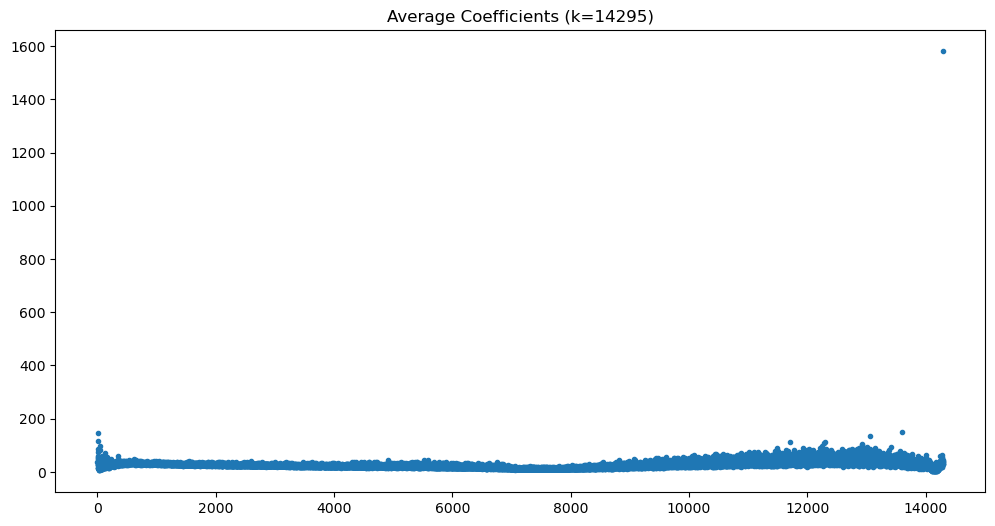

In [11]:
K=14295
#average_coefficients = full_embeddings.mean(axis=0)
sample_embeddings = full_embeddings[torch.randint(0,full_embeddings.shape[0],(1000,))]
# Compute the expectation of the absolute value of the norm of each component.
average_coefficients = sample_embeddings.norm(p=2,dim=0).cpu().numpy()[::-1]
data = average_coefficients[:K]

# Reverse the tensor:
data = data

# Normalize by sum?
#data = data / data.sum()

plt.figure(figsize=(12, 6))
plt.title(f"Average Coefficients (k={K})")
fig= plt.plot(range(K), data,marker='.',linestyle='')


plt.show()

## Principal eigenvalues

[None, None]

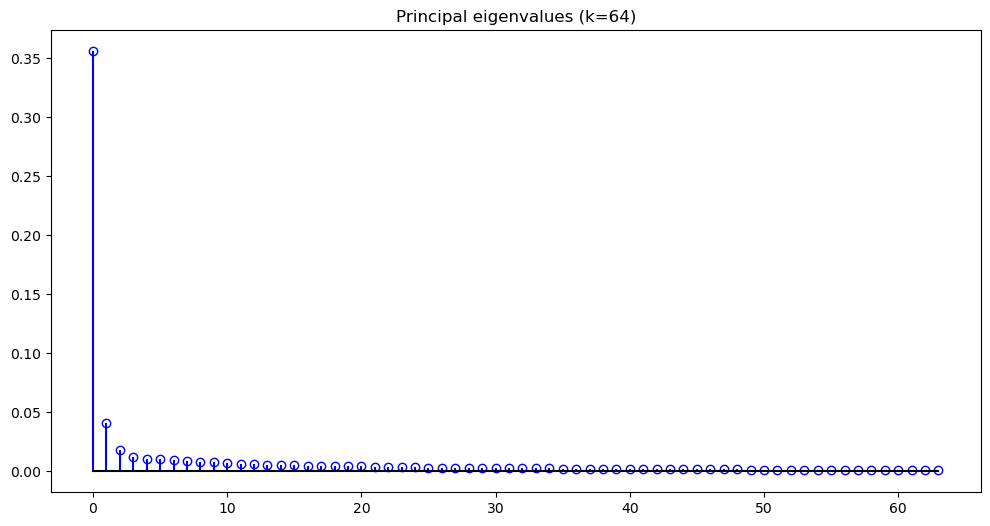

In [12]:
K=64
L_plot = L[-K:]/L.sum()
L_plot,_ = L_plot.sort(descending=True)
L_plot = L_plot.cpu().numpy()
plt.figure(figsize=(12, 6))
plt.title("Principal eigenvalues (k=64)")
markerline, stemlines, baseline = plt.stem(range(K), L_plot, linefmt='b-', markerfmt='o', basefmt='k-')
plt.setp(markerline, marker='o', fillstyle='none')


## Co ocurrence matrix

In [13]:
# Top 10 words
top_10_words = C.sum(axis=0).sort(descending=True).indices[:10]
top_10_words = [vocab[i] for i in top_10_words]
print(top_10_words)

['blessings', 'plebeii', 'fond', 'Shot', 'steely', 'exile', 'pump', 'SERVING', 'utterance', 'stare']


"Top 100 words, excluding punctation and most common stop words: blessings plebeii fond Shot steely exile pump SERVING utterance stare briefly pierced stainless marrying orders portcullis'd unroof'd shorten'd puff fixture became Remit Sinon appeareth o'ercharged appellant's bane delay'd voices sword's Friend butchery greasy brags readiness pedant example Yonder's discoursed fortitude ARCHIDAMUS observed deposing say'st neither takes mad earthen runners trident tortoise Before thimble Nearer faced people vice's Fill'd jealousy adoreth Nobleman choleric robbery spruce signior own skull lesser faster Plainly tinder hinged Emperor mouths craftily brain Northumberland visaged Fortune key crystal advance wrings smack turn'd Marian Follow brought patricians particularly reel refuge ask unmann'd resort Swarming rushes divides blaspheme Drown"

/tmp/ipykernel_1342600/3219164711.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


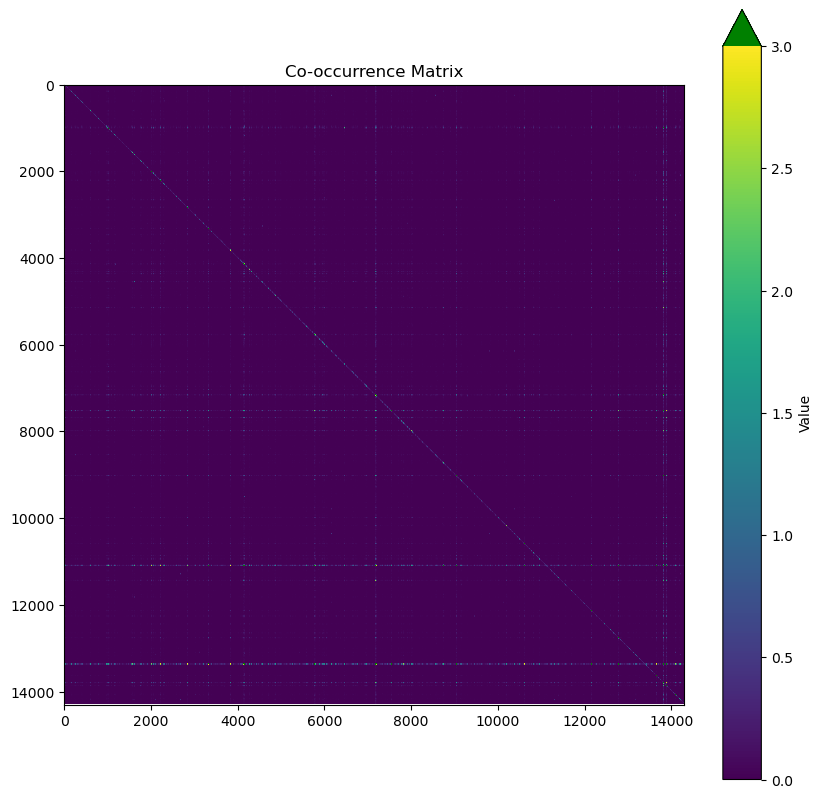

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Remove all the punctations and stop words from the matrix for visualization
X_viz = C.clone()
words_to_remove = [",", ":", ".", "the", "I", "to", "and", ";", "of", "you", "my", "a", "?", "!", "in", "that", "And", "not", "-", "is", "me", "be", "it", "with", "your", "for", "his", "have", "this", "thou", "as", "thy", "will", "so", "but", "The", "To", "all", "her", "thee", "by", "are", "our", "do", "we"]
vocab_to_remove_indices = set(words_to_tokens(words_to_remove))
idx_to_viz = [i for i, word in enumerate(vocab) if word not in vocab_to_remove_indices]
X_viz = X_viz[idx_to_viz, :][:, idx_to_viz]

# top 20 words not including stop words
top_100_words = C.sum(axis=0).sort(descending=True).indices[:100].cpu().numpy()
top_100_nostop = [word for word in top_100_words if word not in vocab_to_remove_indices]
display(f"Top 100 words, excluding punctation and most common stop words: {tokens_to_words(top_100_nostop)}")

# Create a custom colormap
cmap = plt.cm.get_cmap('viridis').copy()
cmap.set_over('green')

# Plot the image with the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(X_viz.cpu().numpy(), cmap=cmap, vmax=3)

# Add colorbar with custom settings
cbar = plt.colorbar(extend='max')
cbar.set_label('Value')

plt.title('Co-occurrence Matrix')
plt.show()
# Model

# Model

## MultiHeadLayer

In [12]:
class MultiHeadLayer(nn.Module):
    """
    An implementation of the multihead attention layer.
    The difference between AttentionLayer and this class is,
    now Q,K,V are matrices of shape (H, m, n), and the attention matrix B is of shape (H, T, T)
    (one attention feature per head)
    Args:
        m (int): The dimension of the Q and K matrices.
        n (int): The number of features, n is the embedding dimension in our case.
        k (int): The dimension of the W matrix.
        H (int): The number of heads.
    """
    def __init__(self, m, n, H):
        super(MultiHeadLayer, self).__init__()
        self.m = m
        self.H = H

        self.Q = nn.Parameter(torch.empty(H, m, n))
        self.K = nn.Parameter(torch.empty(H, m, n))
        self.V = nn.Parameter(torch.empty(H, m, n))

        self.W = nn.Parameter(torch.empty(n, m))
        
        self.nonlinearity = nn.ReLU()
        self.initialize_parameters()
        
        self.norm1 = nn.LayerNorm(n)
        self.norm2 = nn.LayerNorm(n)
        self.dropout = nn.Dropout(0.2)

    def initialize_parameters(self):
        """
        Initialize the values of the learnable parameter matrices.
        Kaiming uniform is just a type of random initialization, you don't need to 
        worry about it. It is a good default initialization for linear layers.
        """
        nn.init.kaiming_uniform_(self.Q, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.K, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.V, a=math.sqrt(5))

        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, X):
        """
        The forward pass of the multihead attention layer, analogous to the one in the 
        AttentionLayer class. The main difference is that we need to make sure that the 
        matrix multiplications account for the new head dimenison.
        Args:
            X (torch.Tensor): The input sequence.
        Returns:
            X_l (torch.Tensor): The output of the multihead attention layer.
        """
        B, n, T = X.shape  # X: (B, n, T)
        
        # Normalize embedding dim. 
        # We permute because nn.LayerNorm always normalizes the last dimension.
        self.norm1(X.permute(0,2,1)).permute(0,2,1)
        

        # Expand X to include the head dimension
        X_expanded = X.unsqueeze(1)  # (B, 1, n, T)

        # Compute QX, KX, VX for each head
        # The unsqueeze is used to add the head dimension to the matrices,
        # because they are of shape (H, m, n), and we need to multiply them
        # with X_expanded of shape (B, 1, n, T)
        QX = torch.matmul(self.Q.unsqueeze(0), X_expanded)  # (B, H, m, T)
        KX = torch.matmul(self.K.unsqueeze(0), X_expanded)  # (B, H, m, T)
        VX = torch.matmul(self.V.unsqueeze(0), X_expanded)  # (B, H, m, T)

        # Transpose QX for multiplication
        
        QX_t = QX.transpose(-2, -1)  # (B, H, T, m)

        # Compute attention scores B per head
        B_matrix = torch.matmul(QX_t, KX)  # (B, H, T, T)

        # Compute attention weights A per head
        A = F.softmax(B_matrix, dim=-1)  # (B, H, T, T)

        # Compute Z per head
        Z = torch.matmul(VX, A)  # (B, H, m, T)

        # Average over the heads
        Z = Z.sum(dim=1)

        # Continue with feed-forward network
        Y_l = torch.matmul(self.W, Z)  # (B, n, T)
        
        # Normalize embedding dim. 
        # We permute because nn.LayerNorm always normalizes the last dimension.
        Y_l = self.norm2(Y_l.permute(0,2,1)).permute(0,2,1)
        
        X_l = X + self.nonlinearity(Y_l)  # (B, n, T)
        
        # Dropout for regularization
        X_l = self.dropout(X_l)

        return X_l



## LLM (todo rename)

In [13]:
class LLM(nn.Module):
    def __init__(self, L, m, H):
        super(LLM, self).__init__()
        self.num_blocks = L
        self.position_embedding = nn.Embedding(T, n) #TO DO replace by actual positional embeddings?
        self.token_embedding = embeddings
        self.decoder_layers = nn.Sequential(*[MultiHeadLayer(m, n, H) for _ in range(L)])
        self.norm = nn.LayerNorm(n)

    def forward(self, tokens):
        token_emb = self.token_embedding[tokens]
        #token_emb = tokens
        pos_emb = self.position_embedding(torch.arange(tokens.shape[1], device=device))
        x = token_emb + pos_emb
        # We permute to get shape of batch (B) x embed_dim (n) x context_size (T): (B, n, T)
        x = x.permute(0,2,1)
        x = self.decoder_layers(x)
        return self.norm(x.permute(0,2,1)).permute(0,2,1)

    def generate(self, input_tokens, max_generate_tokens=500):
        for _ in range(max_generate_tokens):
            logits = self(input_tokens[: , -T:])
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            input_tokens = torch.cat([input_tokens, next_token], dim=1)
        return input_tokens

X_idx = next(iter(train_loader))[0]
model = LLM(L=3, m=128, H=8).to(device)
model(X_idx)[0,0:1,:]

tensor([[-0.5670, -0.4217, -0.6039,  1.7886, -2.9346, -0.2832,  2.3619, -0.5229,
         -0.1694, -0.7228,  0.3794,  0.3862, -0.3920, -0.5731, -0.2387, -1.4514,
         -1.7999, -0.6454, -1.6393, -0.5802,  1.4818, -0.6600,  2.0368, -0.6985,
         -1.0772,  0.0632, -0.4991,  0.4216, -0.5917, -0.5555, -0.5188, -1.7258,
         -0.4518, -0.3359,  0.1947,  0.0096, -0.1133,  0.1981,  0.4868, -0.5822,
         -0.5812,  0.1464, -0.5586,  0.1856, -0.6005,  0.0076, -0.5092, -0.1257,
         -0.1859, -0.6304, -0.6367, -0.3146,  0.7074, -1.3089, -0.4925, -1.5612,
         -0.5425, -0.9185, -0.5428, -1.2007, -0.6108, -1.0165, -1.2957, -0.5993]],
       device='cuda:1', grad_fn=<SliceBackward0>)

## Train

In [15]:

if os.path.exists("./model.pt"):
    model = torch.load("./model.pt", map_location=device)
    print("Loaded existing model")
else:
    L = 3
    H = 8
    m = n//H
    model = LLM(L, m, H).to(device)
    lr = 1e-4
    opt = optim.AdamW(model.parameters(), lr=lr)
    num_epochs = 20
    model.eval()
    num_parameters_str = str(sum(p.numel() for p in model.parameters())/1e6,) + 'M parameters'
    # wandb.config.update({"lr": lr, 
    #                     "num_blocks": num_blocks, 
    #                     "num_heads_per_block": num_heads_per_block,
    #                     "context_size": T,
    #                     "num_epochs": num_epochs,
    #                     "model_summary": str(model),
    #                     "num_parameters": num_parameters_str})
    print("Created new model with {}".format(num_parameters_str))
    train_loss_evolution = []
    for epoch in trange(num_epochs):
        train_loss = 0
        for t_idx, (x, y) in enumerate(train_loader):
            logits = model(x)
            batch_size, _, _ = logits.shape
            #loss = F.cross_entropy(logits.view(batch_size * T, -1), y.view(batch_size * T, -1).squeeze())
            loss = F.cross_entropy(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_loss_evolution.append(train_loss/len(train_loader))
        clear_output()
        print(f"Epoch {epoch+1}, Loss {train_loss/len(train_loader)}")
        run.log({"epoch_train_loss": train_loss/len(train_loader)}) 
        wandb.config.update({"num_epochs": epoch+1})
        plt.plot(train_loss_evolution)
        plt.show()
    torch.save(model, "./model.pt")
    wandb.save('./model.pt')
    

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
test_loss = 0
with torch.no_grad():
    for t_idx, (x, y) in enumerate(test_loader):
        logits = model(x)
        batch_size, _, _ = logits.shape
        loss = F.cross_entropy(logits.view(batch_size * T, -1), y.view(batch_size * T, -1).squeeze())
        test_loss += loss.item()

print("Test loss: ", test_loss / len(test_loader))

In [ ]:
initial = test[132:132+T].unsqueeze(0)
generated_text = "".join(tokens_to_words(model.generate(initial, max_generate_tokens=1000).squeeze().tolist()))
with open("output.txt", "w") as text_file:
    text_file.write(generated_text)

wandb.save("output.txt")
wandb.finish()

In [21]:
torch.release